# Quant Research Starter: Getting Started

This notebook walks through generating or loading data, computing example factors, running a simple backtest, and visualizing results.

Prereqs: `pip install -e .[dev]` from repo root.



In [ ]:
# Ensure package is importable when not using the editable-install kernel
import sys
from pathlib import Path

try:
    import quant_research_starter  # noqa: F401
except ModuleNotFoundError:
    repo_root = Path.cwd()
    candidates = [repo_root, repo_root.parent, repo_root / "QuantReasearchStarter"]
    for c in candidates:
        src = c / "src"
        if (src / "quant_research_starter").exists():
            sys.path.insert(0, str(src.resolve()))
            break

# Show which Python the kernel is using (debugging)
import sys as _sys
print("Kernel Python:", _sys.executable)


Kernel Python: c:\Users\tiwar\anaconda3\python.exe


In [ ]:
# Setup: imports
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

from quant_research_starter.data import SampleDataLoader, SyntheticDataGenerator
from quant_research_starter.factors import MomentumFactor, ValueFactor, SizeFactor, VolatilityFactor
from quant_research_starter.backtest import VectorizedBacktest
from quant_research_starter.metrics import RiskMetrics



In [ ]:
# Load or generate data
loader = SampleDataLoader()
prices = loader.load_sample_prices()
prices.tail()


,SYMBOL_00,SYMBOL_01,SYMBOL_02,SYMBOL_03,SYMBOL_04,SYMBOL_05,SYMBOL_06,SYMBOL_07,SYMBOL_08,SYMBOL_09
date,,,,,,,,,,
2021-05-10,126.037759,154.470167,157.930668,103.695371,123.795450,130.934255,83.509390,106.314250,152.319120,263.900298
2021-05-11,125.297291,151.618018,156.145737,103.886048,122.657097,130.074568,81.736332,106.402090,150.424465,269.354166
2021-05-12,129.190901,154.794713,157.492092,100.639697,117.927592,124.385727,83.441497,107.852380,153.099345,258.716805
2021-05-13,126.160168,154.269278,156.389740,99.982101,118.231142,126.758433,83.000160,107.563488,152.996083,269.447208
2021-05-14,120.926142,151.349653,152.316626,100.016363,116.770184,125.833884,83.320073,112.195261,157.125658,264.849185


In [ ]:
# Compute example factors
mom = MomentumFactor(lookback=63)
val = ValueFactor()
size = SizeFactor()
vol = VolatilityFactor(lookback=21)

f_mom = mom.compute(prices)
f_val = val.compute(prices)
f_size = size.compute(prices)
f_vol = vol.compute(prices)

# simple composite
signals = pd.DataFrame({
    'momentum': f_mom.mean(axis=1),
    'value': f_val.mean(axis=1),
    'size': f_size.mean(axis=1),
    'volatility': f_vol.mean(axis=1),
})
signals['composite'] = signals.mean(axis=1)
signals.tail()


,momentum,value,size,volatility,composite
date,,,,,
2021-05-10,-0.038686,1.276756e-16,5.773160e-16,-1.443290e-16,-0.009671
2021-05-11,-0.020026,-3.747003e-17,0.000000e+00,5.551115e-16,-0.005006
2021-05-12,-0.023149,2.109424e-16,-3.108624e-16,-3.774758e-16,-0.005787
2021-05-13,-0.042553,-3.261280e-17,2.975398e-15,-7.577272e-16,-0.010638
2021-05-14,-0.017899,9.159340e-17,-3.907985e-15,-4.357625e-16,-0.004475


In [ ]:
# Backtest
common = prices.index.intersection(signals.index)
px = prices.loc[common]
sg = pd.DataFrame({c: signals['composite'] for c in px.columns}, index=signals.index).loc[common]

bt = VectorizedBacktest(px, sg, initial_capital=100000)
results = bt.run(weight_scheme="rank")

metrics = RiskMetrics(results['returns']).calculate_all()
metrics


Running backtest...


{'total_return': -1.0,
 'cagr': 0,
 'annualized_return': 0,
 'volatility': nan,
 'downside_volatility': nan,
 'max_drawdown': 0.0,
 'drawdown_duration': 0,
 'var_95': -1.0,
 'cvar_95': -1.0,
 'sharpe_ratio': 0,
 'sortino_ratio': 0,
 'calmar_ratio': 0}

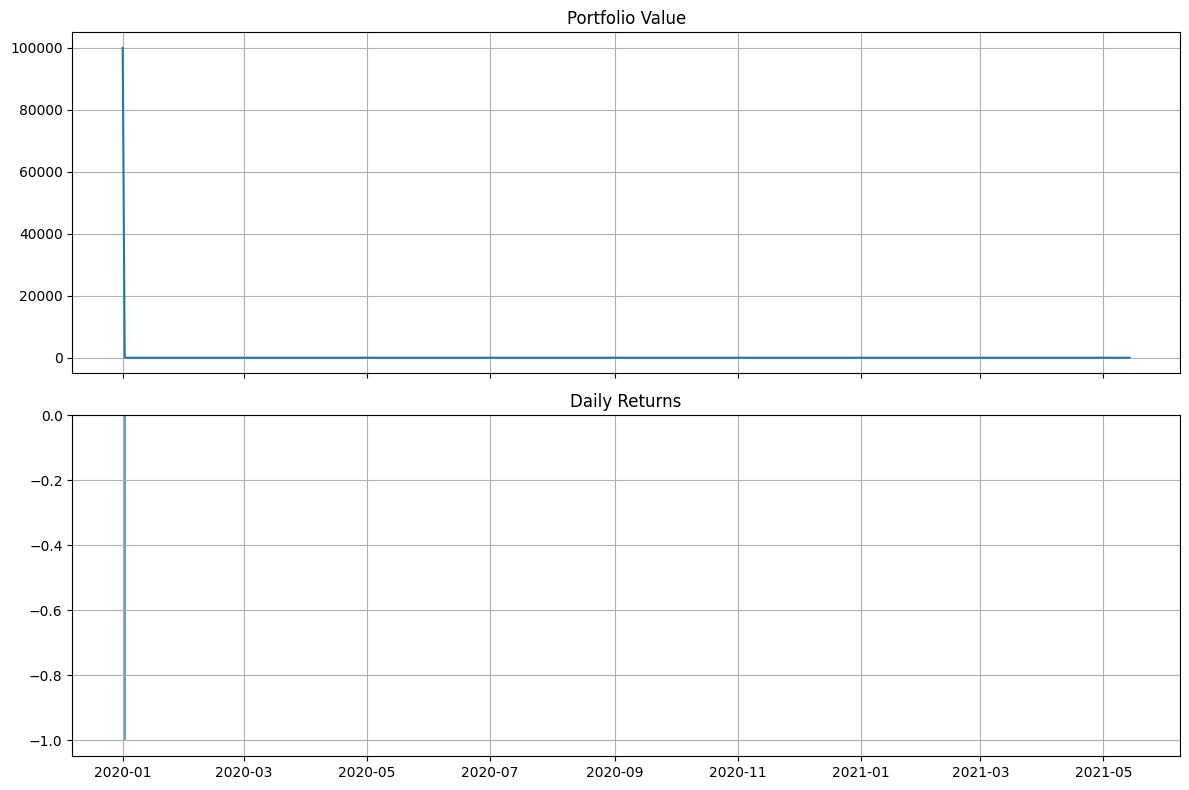

In [ ]:
# Plot equity curve and returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax1.plot(results['portfolio_value'].index, results['portfolio_value'].values)
ax1.set_title('Portfolio Value')
ax1.grid(True)

ax2.bar(results['returns'].index, results['returns'].values, alpha=0.7)
ax2.set_title('Daily Returns')
ax2.grid(True)
plt.tight_layout()
plt.show()


## Next steps
- Try different factor lookbacks (e.g., 21/63/126 for momentum).
- Swap weight scheme: `rank`, `zscore`, `long_short`.
- Add your own factor by creating a file in `src/quant_research_starter/factors/` and importing it here.

